In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
eps = 0.007 # 노이즈 크기
use_cuda = True # 학습 또는 추론 시 GPU(CUDA)를 사용할지 여부
# GPU: 딥러닝 연산을 빠르게 해주는 하드웨어
# CUDA: NVIDIA GPU를 제어하고 계산을 실행할 수 있게 해주는 소프트웨어 라이브러리 및 API

In [4]:
# ImageNet 분류 결과를 사람이 읽을 수 있는 라벨로 변환하기 위한 준비 작업
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
# str(k): JSON 키는 문자열이므로 인덱스를 문자열로 변환
# class_idx[str(k)][1]: 해당 키의 두 번째 항목, 즉 라벨 이름만 가져옴

# idx2label = [
#   "tench",          # index 0
#   "goldfish",       # index 1
#   "great_white_shark",  # index 2
#   ...
#   "toilet_tissue"   # index 999
# ]


In [5]:
# 이미지 데이터를 딥러닝 모델에 맞게 전처리(Preprocessing)
transform = transforms.Compose([
    transforms.Resize((299, 299)), # 1단계: 크기 조절(보통의 사이즈)
    transforms.ToTensor(), # 2단계: Tensor로 변환, ToTensor : [0, 255] -> [0, 1]
])
# 파이프라인: 여러 작업을 차례대로 자동 처리하는 구조
# Compose([...]): 여러 전처리들을 순서대로 묶는 함수

In [9]:
# torchvision.datasets.ImageFolder를 기반으로 사용자 정의 라벨을 적용할 수 있게 만들어주는 함수
# torchvision.datasets.ImageFolder? PyTorch에서 이미지 분류용 데이터셋을 쉽게 불러올 수 있게 해주는 클래스
# ImageFolder는 폴더 이름을 클래스 이름으로 보고, 그 하위에 있는 이미지들을 자동으로 불러와서 라벨링 함.

def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    # 왼쪽 root는 ImageFoler()에 전달되는 매개변수 이름
    # 오른쪽 root는 image_folder_custom_label()로 전달된 인자 값
    # 즉 외부 함수에서 받은 값을 내부 함수에 동일한 이름으로 전달할 때
    old_classes = old_data.classes 
    # old_data.classes: 이미지 폴더의 클래스 이름(=폴더 이름) 목록
    
    label2idx = {}
    # "라벨 이름 -> 인덱스" 매핑을 저장하기 위한 빈 딕셔너리 선언
    
    for i, item in enumerate(idx2label) : # idx2label: 숫자 인덱스
        label2idx[item] = i # enumerate()는 리스트를 순회하면서 i는 인덱스, item은 라벨 이름을 가져옴.
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    # 기본 라벨 인덱스 -> custom_label 인덱스로 변환
    # custom_label.index(...): 그 라벨 이름이 custom_label에서 몇 번째인지 계산
    
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx
    # ImageFolder는 내부적으로 class_to_idx의 값과 classes의 인덱스가 일치해야 한다는 것을 전제로 함.
    # ImageNet은 1000개의 클래스로 구성되어 있어 0~999 사이의 정수(클래스 인덱스)로 결과를 보여줌.
    # If, 결괏값이 934이고, 기존 ImageFolder 속에 3개의 클래스만 있었으면 IndexError가 발생하기 때문에 강제로 전체 ImageNet 라벨 1000개를 넣어둠.

    return new_data

In [ ]:
normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)
# batch_size=1: 한 번에 하나의 샘플을 꺼냄.
# shuffle=False: 순서를 섞지 않고 순차적으로 꺼냄.

In [17]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


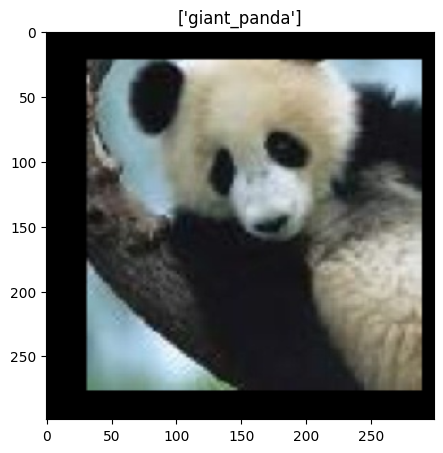

In [18]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

In [ ]:
# Inception v3는 구글이 개발한 이미지 분류를 위한 딥러닝 모델
# 현재 설치된 PyTorch는 CUDA(GPU)를 지원하지 않아서 use_cuda=False를 추가로 작성함.
# 현재 CPU 사용중
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
# use_cuda가 True면 "cuda"사용
# use_cuda가 False면 "cpu"사용

In [24]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).to(device)
model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

True Image & Predicted Label


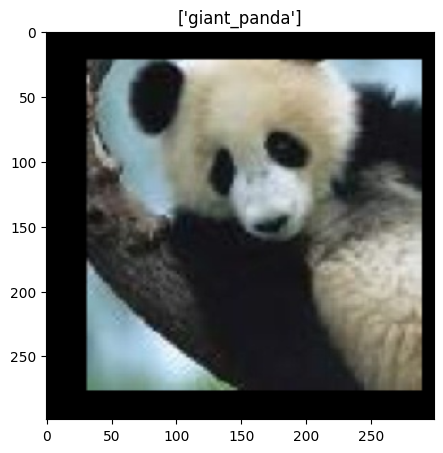

Accuracy of test text: 100.000000 %


In [ ]:
# < 정상 이미지 테스트 결과 >
print("True Image & Predicted Label")

model.eval()
# 모델을 추론모드로 전환

correct = 0 # 맞은개수
total = 0 # 전체개수

for images, labels in normal_loader: # normal_loader에서 하나의 이미지와 라벨 쌍을 가져옴.
    
    images = images.to(device)
    labels = labels.to(device)
    # 모델과 동일한 디바이스(CPU or GPU)로 이미지와 정답 라벨 이동시킴.
    outputs = model(images)
    # 모델에 이미지를 넣고 예측 결과를 얻음.
    
    _, pre = torch.max(outputs.data, 1)
    # 예측 확률이 가장 높은 클래스의 인덱스를 pre에 저장
    # torch.max(tensor, dim)함수
    # values, indices = torch.max(tensor, dim)
    # tensor: 예측 결과 텐서
    # dim: 어떤 축에서 max를 구할지 지정(dim=1이면 행마다)
    # values: 가장 큰 값, indices: 가장 큰 값의 인덱스
    
    total += 1 
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 100.000000 %
:
Inception v3 모델이 정상 이미지에 대해서는 모든 이미지를 정확하게 예측했다는 의미

In [ ]:
def fgsm_attack(model, loss, images, labels, eps) :
    # model: 사용할 딥러닝 모델
    # loss: 손실 함수
    # images: 입력 이미지들 (배치 단위)
    # labels: 정답 레이블
    # eps: ε (작은 값, 공격 강도 조절)
    
    images = images.to(device)
    labels = labels.to(device)
    # 이미지와 레이블 데이터를 CPU로 이동시킴.
    images.requires_grad = True
    # 이미지 텐서에 대해 미분 가능하게 설정함.
            
    outputs = model(images)
    # 현재 이미지들을 모델에 넣어 예측 결과를 얻음.
    
    model.zero_grad()
    # 모델의 기존 gradient를 초기화함.
    cost = loss(outputs, labels).to(device)
    # 모델 출력과 정답 라벨을 비교해서 손실을 계산함.
    cost.backward()
    # 손실함수에 대한 역전파 수행
    # 역전파: 딥러닝 모델이 학습하는 과정에서 손실(오차)가 왜 생겼는지를 거꾸로 올라가 각 가중치와 입력이 오차에 얼마나 영향을 줬는지(기울기) 계산하는 과정
    # 이 과정에서 이미지에 대한 gradient가 계산된다.
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [28]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


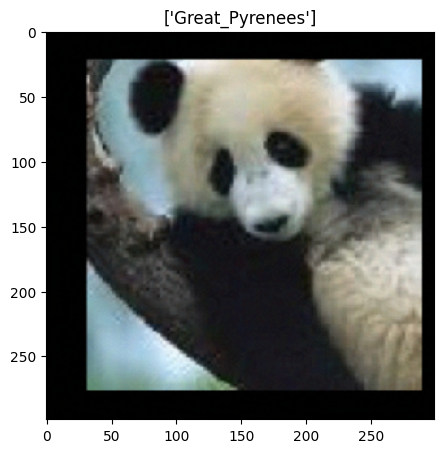

Accuracy of test text: 0.000000 %


In [30]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = fgsm_attack(model, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 0.000000 %
:
FGSM으로 생성한 적대적 이미지에 대해 모델이 모든 예측을 틀림.